In [1]:
# http://140.115.25.183/user/chan_jung/lab

# Import

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as dset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import scipy.io
from PIL import Image
from tqdm import tqdm

In [2]:
class DoubleConv(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        # nn.GroupNorm(1, out_c), #equivalent with LayerNorm
        nn.BatchNorm2d(out_c), # 取平均，比較不會Overfitting
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        # nn.GroupNorm(1, out_c), #equivalent with LayerNorm
        nn.BatchNorm2d(out_c), # 取平均，比較不會Overfitting
        nn.ReLU()
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    return x

class Down(nn.Module):
  def __init__(self, in_c, out_c, emb_dim=128):
    super().__init__()
    self.down = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_c,out_c),
    )

    self.emb_layer = nn.Sequential(
        nn.ReLU(),
        nn.Linear(emb_dim, out_c),
    )

  def forward(self, x, t):
    x = self.down(x)
    #擴充兩個dimension，然後使用repeat填滿成和圖片相同(如同numpy.tile)
    t_emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
    return x + t_emb

class Up(nn.Module):
    def __init__(self, in_c, out_c, emb_dim=128):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = DoubleConv(in_c,out_c)
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_c),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class Unet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=128):
        super().__init__()
        self.device = device
        self.time_dim = time_dim

        self.inc = DoubleConv(c_in, 64) #(b,3,64,64) -> (b,64,64,64)

        self.down1 = Down(64, 128) #(b,64,64,64) -> (b,128,32,32)
        self.sa1 = SelfAttention(128, 16) #(b,128,32,32) -> (b,128,32,32)
        self.down2 = Down(128, 256) #(b,128,32,32) -> (b,256,16,16)
        self.sa2 = SelfAttention(256, 8) #(b,256,16,16) -> (b,256,16,16)
        self.down3 = Down(256, 256) #(b,256,16,16) -> (b,256,8,8)
        self.sa3 = SelfAttention(256, 4) #(b,256,8,8) -> (b,256,8,8)

        self.bot1 = DoubleConv(256, 512) #(b,256,8,8) -> (b,512,8,8)
        self.bot2 = DoubleConv(512, 512) #(b,512,8,8) -> (b,512,8,8)
        self.bot3 = DoubleConv(512, 256) #(b,512,8,8) -> (b,256,8,8)

        self.up1 = Up(512, 128) #(b,512,8,8) -> (b,128,16,16) because the skip_x
        self.sa4 = SelfAttention(128, 8) #(b,128,16,16) -> (b,128,16,16)
        self.up2 = Up(256, 64) #(b,256,16,16) -> (b,64,32,32)
        self.sa5 = SelfAttention(64, 16) #(b,64,32,32) -> (b,64,32,32)
        self.up3 = Up(128, 64) #(b,128,32,32) -> (b,64,64,64)
        self.sa6 = SelfAttention(64, 32) #(b,64,64,64) -> (b,64,64,64)

        self.outc = nn.Conv2d(64, c_out, kernel_size=1) #(b,64,64,64) -> (b,3,64,64)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
         10000
         ** (torch.arange(0, channels, 2, device=t.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        # (bs,) -> (bs, time_dim)
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        #initial conv
        x1 = self.inc(x)

        #Down
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        #Bottle neck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        #Up
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)

        #Output
        output = self.outc(x)
        return output

# Initail

In [34]:
batch = 128 # Max:128
T = 1
N = 1000
dt = T/N
epoch = 10
save_name = 'eps_theta_SMLD_7'
DOWNLOAD_MNIST = False
device_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_str)
# device = torch.device("cpu")
print(device)

cuda


# Loading Data and Data Preprocessing

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,) ,(0.5,)),
]
)


trainset = torchvision.datasets.MNIST(
    root = 'dataset/mnist',
    train = True,
    transform = data_transform, #改成torch可讀
    download = DOWNLOAD_MNIST,
)

In [5]:
trainLoader = dset.DataLoader(trainset, batch_size = batch, shuffle=True)

# training

In [35]:
sigma_max = 10.0
sigma_min = 0.01

# discrete
lin_t = torch.linspace(0, T, N).to(device)
sigma_list = sigma_min * (sigma_max / sigma_min)**(lin_t)


In [17]:
eps_theta = Unet().to(device)

optimizer = torch.optim.Adam(eps_theta.parameters(), lr=0.001)
loss_func = nn.MSELoss()

loss_set = []
batch_loss = []

pbar = tqdm(range(epoch))
for ep in pbar:
    for X_data, train_labels in trainLoader:
        # with torch.autocast(device_type=device_str, dtype=torch.bfloat16):
        X_data = X_data.to(device)

        # Euler-Maruyama method
        time = (torch.randint(N, size=(X_data.shape[0],), device=device) +1)

        noise = torch.randn_like(X_data)

        Xt = X_data + (sigma_list[time-1, None, None, None]**2 - sigma_min**2).sqrt() * noise

        prediction = eps_theta(Xt, time-1)
        loss = torch.mean(torch.square((prediction + noise)))

        # 訓練網路三個最主要步驟
        optimizer.zero_grad() # 梯度清0
        loss.backward() # 誤差反向傳導
        optimizer.step() # 神經網路參數更新
        pbar.set_description('Loss: {}'.format(loss.item()))
        # print(prediction.shape, noise.shape, loss.shape)
        loss_set.append(loss.item())


NameError: name 'Unet' is not defined

In [8]:
try:
    checkpoint
except NameError:
    epoch_last = 0
else:
    epoch_last = checkpoint["epoch"]
torch.save({
    'epoch': epoch_last + epoch,
    # 'model': eps_theta,
    'model_state_dict': eps_theta.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_set': loss_set
    },  f"Model/{save_name}.pt")
iteration = np.arange(len(loss_set))
fig = plt.figure()
plt.loglog(iteration, loss_set, "-")
plt.savefig(f"Figure/{save_name}.png")
plt.close()

# Sampling

In [49]:
# the O-U process
# dXt  = -beta/2*dXt*dt + sqrt(beta)*dWt
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

# eps_theta = torch.load( "Model/eps_theta_SMLD_4.pt", map_location = device)

# eps_theta = Unet().to(device)
# checkpoint = torch.load("Model/eps_theta_SMLD_4.pt")
# checkpoint = torch.load(f"Model/{save_name}.pt")
# eps_theta.load_state_dict(checkpoint['model_state_dict'])

X_T = torch.randn(16, 1, 32, 32).to(device)
X_data, _ = next(iter(trainLoader))
X_data = torch.Tensor(X_data[0:64]).to(device)
# print(X_data.shape)
# X_0, _ = next(iter(trainLoader))
# X_data = torch.Tensor(X_data).to(device)
with torch.no_grad() :

    # mu = torch.mean(X_data, dim = 1)
    x = torch.randn_like(X_data, device = device) * np.sqrt(sigma_max**2 - sigma_min**2) + X_data # 原X_T分布
    x_motion = x.unsqueeze(-1)

    # score_exact = lambda x, t: -(x - mu_t(X_data,t) ) / sigma_t(t)**2
    # eps_exact   = lambda x, t: -sigma_t(t) * score_exact(x,t) #-beta*score_exact(x,t)
    score_exact = lambda x, t: -(x - X_data) / (sigma_list[t]**2 - sigma_min**2)
    eps_exact   = lambda x, t: -(sigma_list[t]**2 - sigma_min**2).sqrt() * score_exact(x,t) #-beta*score_exact(x,t)

    for i in range(N,1,-1):
        idx = torch.ones(len(x)).to(device) * (i-1)
        # prediction = eps_theta(x, idx)

        g_t = sigma_list[i-1] * (2/T*torch.log(torch.Tensor([sigma_max/sigma_min]).to(device))*dt).sqrt()

        # x = x + g_t**2 * prediction/(sigma_list[i-1]**2 - sigma_min**2).sqrt() + g_t * torch.randn_like(x)

        x = x + g_t**2 * score_exact(x,i-1) + g_t * torch.randn_like(x) 
        # x = x - g_t**2 * eps_exact(x,i-1)/(sigma_list[i-1]**2 - sigma_min**2).sqrt() + g_t * torch.randn_like(x) 

        x_motion = torch.hstack([x_motion, x.unsqueeze(-1)])
    # x = (x - (1-alpha[0])/torch.sqrt(1-alpha_bar[0]) * eps_exact(x,idx)) / torch.sqrt(alpha[0])
    idx = torch.ones(len(x)).to(device) * 1
    # prediction = eps_theta(x, idx)

    g_t = sigma_list[i-1]**2 * 2/T*torch.log(torch.Tensor([sigma_max/sigma_min]).to(device))*dt
    # x = x + g_t * prediction
    x = x + g_t * eps_exact(x,-1)
    
    
    # print((beta * prediction).shape, x.shape)
    x_motion = torch.hstack([x_motion, x.unsqueeze(-1)])

    print(torch.mean(x), torch.std(x))

tensor(0.1294, device='cuda:0') tensor(0.2851, device='cuda:0')


In [20]:
print(x_motion.shape)
# print(torch.mean(Xt), torch.std(Xt))

torch.Size([64, 501, 32, 32, 1])


In [50]:
x = x.cpu().numpy()
x_motion = x_motion.cpu().numpy()

In [30]:
# print(X_data.shape)

# # plt.imshow(X_data[0], cmap = 'gray')
# plt.imshow(X_data.cpu().numpy()[2][0], cmap = 'gray')
# plt.axis("off")
# plt.show()

(64, 1, 32, 32)


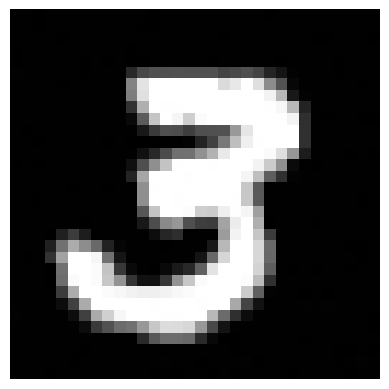

In [51]:
print(x.shape)

plt.imshow(x_motion[0][-1], cmap = 'gray')
# plt.imshow(X_data.cpu().numpy()[0][0], cmap = 'gray')
plt.axis("off")

plt.show()

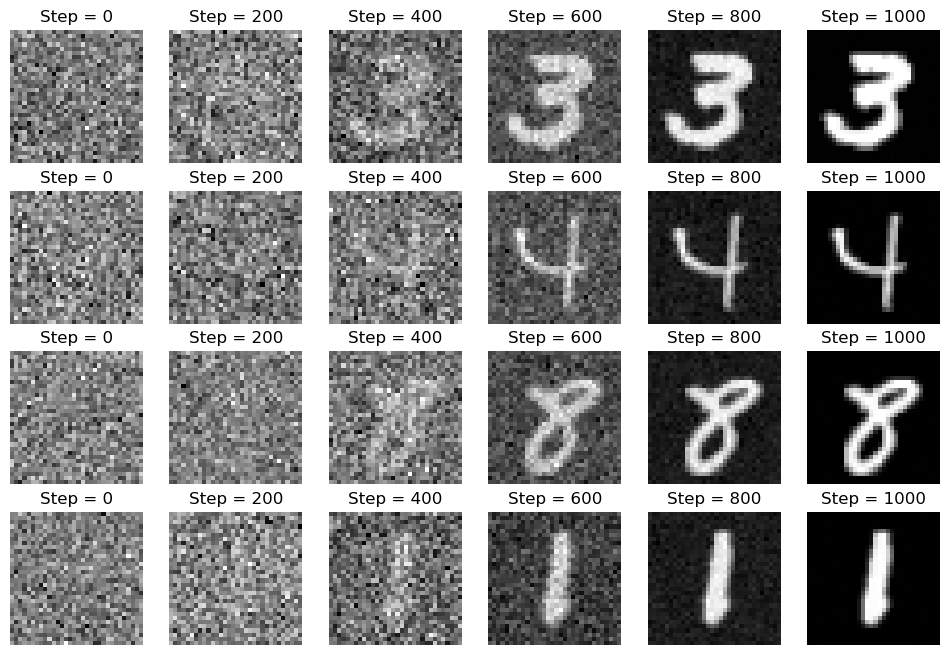

In [52]:
num_fig = 4
steps = 200
num_steps = int(N/steps)+1
# N=1000

plt.figure(figsize=(2*num_steps, 2*num_fig))

for j in range(num_fig):
    k = 0
    for i in range(0, N+1, steps):
        plt.subplot(num_fig, num_steps, k + num_steps*j+1)     #将窗口分为两行两列四个子图，则可显示四幅图片
        plt.title('Step = {}'.format(i))   #第一幅图片标题
        plt.imshow(x_motion[j][i], cmap = "gray")      #绘制第一幅图片
        plt.axis("off")
        k = k+1

        # plt.pause(1)


# plt.show()   #显示窗口
# plt.savefig("SM_sample_XT")   #显示窗口

In [ ]:
# import os

# # 停止 JupyterHub 伺服器
# os.system("pkill -f 'jupyterhub'") 

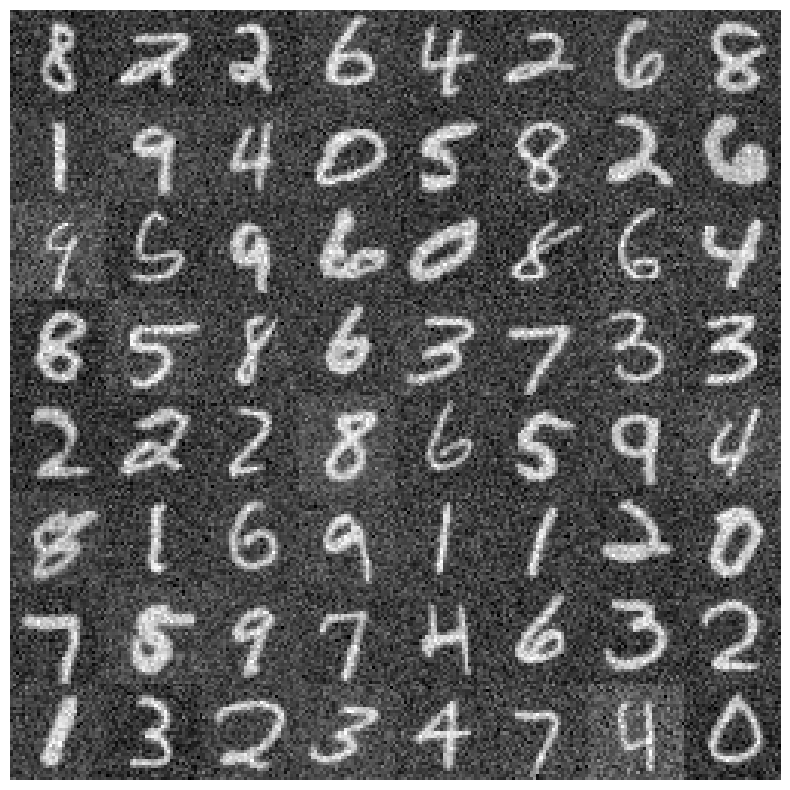

In [17]:
num_fig = 8
steps = int(N/5)
num_steps = int(N/steps)+1
# N=1000

fig = plt.figure(figsize=(num_fig, num_fig))

for j in range(num_fig**2):
    plt.subplot(num_fig, num_fig, j+1)     #将窗口分为两行两列四个子图，则可显示四幅图片
    # plt.title('Step = {}'.format(N - i))   #第一幅图片标题
    plt.imshow(x_motion[j][-1], cmap = "gray")      #绘制第一幅图片
    plt.axis("off")
    # plt.pause(1)

fig.tight_layout()
plt.subplots_adjust(wspace = 0, hspace = 0)

# plt.show()   #显示窗口
# plt.savefig("SMLD")   #显示窗口

In [ ]:
num_fig = 64

for j in range(64):
    plt.imshow(x_motion[j][-1], cmap = "gray")      #绘制第一幅图片
    plt.axis("off")
    # plt.pause(1)
    plt.savefig(f"test_SMLD_sample_figure/sample_figure{j}")   #显示窗口


# Retraining

In [ ]:
eps_theta = Unet().to(device)

optimizer = torch.optim.Adam(eps_theta.parameters(), lr=0.001)
# loss_func = nn.MSELoss()

checkpoint = torch.load(f"Model/{save_name}.pt")
eps_theta.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
loss_set = checkpoint["loss_set"]


pbar = tqdm(range(10))


for ep in pbar:
    for X_data, train_labels in trainLoader:
        # with torch.autocast(device_type=device_str, dtype=torch.bfloat16):
        X_data = X_data.to(device)

        time = (torch.randint(N, size=(X_data.shape[0],), device=device) +1)
        noise = torch.randn_like(X_data)

        Xt = X_data + (sigma_list[time-1, None, None, None]**2 - sigma_min**2).sqrt() * noise

        prediction = eps_theta(Xt, time-1)
        loss = torch.mean(torch.square((prediction + noise)))

        # 訓練網路三個最主要步驟
        optimizer.zero_grad() # 梯度清0
        loss.backward() # 誤差反向傳導
        optimizer.step() # 神經網路參數更新
        pbar.set_description('Loss: {}'.format(loss.item()))
        # print(prediction.shape, noise.shape, loss.shape)
        loss_set.append(loss.item())



In [ ]:
try:
    checkpoint
except NameError:
    epoch_last = 0
else:
    epoch_last = checkpoint["epoch"]
torch.save({
    'epoch': epoch_last + epoch,
    # 'model': eps_theta,
    'model_state_dict': eps_theta.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_set': loss_set
    },  f"Model/{save_name}.pt")
iteration = np.arange(len(loss_set))
fig = plt.figure()
plt.loglog(iteration, loss_set, "-")
plt.savefig(f"Figure/{save_name}.png")
plt.close()